# **Homework 3 - Convolutional Neural Network**

This is the example code of homework 3 of the machine learning course by Prof. Hung-yi Lee.

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.


There are three levels here:

**Easy**: Build a simple convolutional neural network as the baseline. (2 pts)

**Medium**: Design a better architecture or adopt different data augmentations to improve the performance. (2 pts)

**Hard**: Utilize provided unlabeled data to obtain better results. (2 pts)

## **About the Dataset**

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data.
Please DO NOT access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## **Import Packages**

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [2]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
from copy import deepcopy
import seaborn as sns

# This is for the progress bar.
from tqdm.notebook import tqdm

## **Dataset, Data Loader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
# tfm_norm = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
tfm_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize(256),
    transforms.RandomRotation(180, expand=True),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.25, saturation=.15, hue=0.05),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.05, 0.15), ratio=(0.5, 1.5), value=0, inplace=False),
    tfm_norm
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    tfm_norm
])


In [4]:
class RandomTransformDataset:
    def __init__(self, dataset, transform, random_time):
        self.dataset = dataset
        self.transform = transform
        self.random_time = random_time
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        jpg, _ = self.dataset[idx]
        imgs = [self.transform(jpg) for i in range(self.random_time)]
        return torch.stack(imgs, 0)
    
    @staticmethod
    def merge_batch(imgs):
        # (batch, RANDOM_NUM, 3, shape0, shape1)
        return imgs.reshape(-1, *imgs.shape[2:])
    
    def merge_predict(self, predicts):
        # (batch*RANOM_NUM, 11)
        res = []
        labels = torch.argmax(predicts, dim=1).squeeze()
        # (batch*RANOM_NUM)
        for prob in torch.split(labels, self.random_time):
            # (RANDOM_NUM)
            # voting
            res.append(torch.argmax(torch.bincount(prob)))
        # (batch)
        return  res



In [5]:
onehot_lookup = torch.eye(11)
def onehot(label):
    return onehot_lookup[label]

In [6]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
data_folder = "/data/ML2021/hw3/"

train_set = DatasetFolder(data_folder+"food-11/training/labeled", loader=lambda x: Image.open(x),extensions="jpg", transform=train_tfm, target_transform=onehot)
valid_set = DatasetFolder(data_folder+"food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm, target_transform=onehot)
# test_set = DatasetFolder(data_folder+"food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

unlabeled_set = DatasetFolder(data_folder+"food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
unlabeled_set.classes = train_set.classes
unlabeled_set.class_to_idx = train_set.class_to_idx

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
train_loader_noshuf = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
unlab_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
RANDOM_NUM = 16
test_set = DatasetFolder(data_folder+"food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=None)
rd_test_set = RandomTransformDataset(test_set, train_tfm, random_time=RANDOM_NUM)
rd_test_loader = DataLoader(rd_test_set, batch_size=batch_size//RANDOM_NUM*2, shuffle=False, num_workers=16)
test_loader = DataLoader(DatasetFolder(data_folder+"food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm), batch_size=batch_size, shuffle=False, num_workers=16)


## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [8]:
class BlockLinear(nn.Module):
    def __init__(self, ch_in, ch_out, act=None, use_bn=True, drop=0):
        super(BlockLinear, self).__init__()
        list = [
            nn.Linear(ch_in, ch_out)
        ]
        if use_bn: list.append(nn.BatchNorm1d(ch_out))
        if act: list.append(act)
        if drop > 0: list.append(nn.Dropout(drop))
        self.net = nn.Sequential(*list)

    def forward(self, x):
          return self.net(x)

In [9]:
# m = torchvision.models.resnet18(pretrained=False)
# for i, j in (m.state_dict().items()):
    # print(i, "\t", j.shape)
# (m.fc.in_features)
# (m.__class__.__name__)

In [10]:
class Classifier(nn.Module):
    def __init__(self, encoder, linears=[], drop=.3):
        super(Classifier, self).__init__()
        # input image size: [3, 224, 224]
        self.name = f'{encoder.__name__}_{"_".join([str(n) for n in linears])}'
        self.encoder = encoder(pretrained=False)
        self.dim = self.encoder.fc.in_features
        # self.encoder.fc = BlockLinear(512, 128, act=nn.ReLU(), use_bn=True)
        # self.n = [512, 128]
        self.n = [self.dim] + linears
        self.l = len(self.n)
        fc = [
            BlockLinear(self.n[i], self.n[i+1], act=nn.ReLU(), use_bn=True, drop=drop)
            for i in range(self.l-1)
        ]
        self.encoder.fc = nn.Sequential(*fc)
        self.out = nn.Linear(self.n[-1], 11)

    def forward(self, x):
        x = self.encoder(x)
        x = self.out(x)
        return x

    def ema_update(self, target, alpha):
        one_minus_alpha = 1. - alpha
        with torch.no_grad():
            for para, tar in zip(self.parameters(), target.parameters()):
                para.sub_(one_minus_alpha * (para - tar))
            
            for para, tar in zip(self.buffers(), target.buffers()):
                if para.dtype == torch.float:
                    para.sub_(one_minus_alpha * (para - tar))
                else:
                    para.copy_(tar)

            # model_params = OrderedDict(self.named_parameters())
            # tar_params = OrderedDict(target.named_parameters())
            # assert model_params.keys() == tar_params.keys()

            # for name, param in tar_params.items():
            #     # see https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
            #     # shadow_variable -= (1 - decay) * (shadow_variable - variable)
            #     model_params[name].sub_(one_minus_alpha * (model_params[name] - param))

## **Training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [11]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(52728)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
# Explicitly define the psudolabels in Subset class
class SubsetCustomLabel:
    def __init__(self, dataset, labels, indices):
        self.dataset = dataset
        self.labels = labels
        self.indices = indices

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]][0], self.labels[idx]
    
    def set_transform(self, transform):
        self.dataset.transform = transform


In [13]:
class Log:
    def __init__(self, log_path='log', clear=True):
        self.log_path = log_path
        if clear: self.clean_file()
        self.log = open(log_path, 'a')
    
    def clean_file(self):
        if self.log_path in os.listdir():
            os.remove(self.log_path)
            print('remove log')
        
    def flush(self):
        self.log.flush()
    
    def write(self, log_str, is_print=True):
        self.log.write(log_str + "\n")
        if is_print: print(log_str)
    
    def write_epoch(self, total, cur, sections, is_write=True, is_print=True):
        log_str = f"[ {cur + 1:03d}/{total:03d} ]"
        for n, s in sections:
            log_str += f" {self.section(n, s)}"
        if is_write: self.write(log_str, is_print=is_print)
        else: return log_str
    
    def section(self, dest, dict):
        log_str = f"[ {dest:<5} |"
        flg = False
        for n, v in dict.items():
            if flg:
                log_str += ","
            log_str += f" {n} = {v:.5f}"
            flg = True
        log_str += " ]"
        return log_str
    

In [14]:
def get_pseudo_labels(model, dataloader, threshold=0.5, tempreture=3, is_labeled=False, labeld_alpha=.5):
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)
    idx = []
    targets = []
    if is_labeled:
        count = torch.zeros((11, 11), dtype=torch.float32)
    else:
        count = torch.zeros(11, dtype=torch.float32)
    # Iterate over the dataset by batches.
    for i, batch in tqdm(enumerate(dataloader), leave=False, desc='PseudoLabels'):
        img, ans = batch
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits/tempreture)
        
        # Filter the data and construct a new dataset.
        probs1 = probs.max(dim=1).values
        # st = torch.topk(probs, 2, dim=1)
        # probs1 = st[0][:, 0]
        # probs2 = st[0][:, 1]
        # select = (probs1 > threshold) & ((probs1-probs2) > .25)
        select = (probs1 > threshold)
        if not select.any():
            continue
        # targets += st[1][select, 0].tolist()
        probs_arg = probs[select].argmax(dim=1)

        if is_labeled:
            count += probs.sum(dim=0).cpu()
            # l = ans.to(device).argmax(dim=-1)
            # u, id = torch.unique(l.cpu(), return_inverse=True)
            # for i in u:
            #     count[i] += nn.functional.softmax(logits.cpu()[u[id]==i], dim=1).sum(dim=0)
            targets.append(probs.cpu()*(1-labeld_alpha) + ans*labeld_alpha)
        else:
            # targets += probs_arg.tolist()
            # c = torch.bincount(probs_arg).cpu()
            targets.append(probs[select].cpu())
            c = probs[select].sum(dim=0).cpu()

            count[:len(c)] += c
            idx += (torch.where(select)[0] + batch_size*i).tolist()

    # custom subset
    targets = torch.cat(targets, dim=0)
    if is_labeled:
        new = SubsetCustomLabel(dataloader.dataset, targets, torch.arange(len(dataloader.dataset)).tolist())
    else:
        new = SubsetCustomLabel(dataloader.dataset, targets, idx)
    model.train()
    return new, count

def get_semi_set(model, threshold=0.5, tempreture=5):
    unlabeled_set.transform = tfm_weak
    train_set.transform = tfm_weak
    
    pseudo_set, count = get_pseudo_labels(
        model, unlab_loader, threshold=threshold, tempreture=tempreture)
    log.write(f"Use pseudo label: {len(pseudo_set)}")
    log.write("Pseudo Labels Distribution:\n" + 
        ", ".join([f'{i+1:02d}: {w*100:05.2f}' for i, w in enumerate(count/count.sum())]))
    
    labeled_set, confusion = get_pseudo_labels(
        model, train_loader_noshuf, threshold=threshold, tempreture=tempreture, is_labeled=True, labeld_alpha=0.5)
    
    # log.write("GT Labels Distribution:\n" + 
        # ", ".join([f'{i+1:02d}: {w*100:05.2f}' for i, w in enumerate(count2/count2.sum())]))
    
    # count += count2
    # concat_dataset = ConcatDataset([train_set, pseudo_set])
    # concat_dataset = ConcatDataset([labeled_set, pseudo_set])
    # loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)

    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
    pseudo_loader = DataLoader(pseudo_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
   
    unlabeled_set.transform = tfm_strong
    train_set.transform = tfm_strong
    return labeled_loader, pseudo_loader, confusion
    # return loader, count

In [15]:
def train(model, loader, criterion, shadow_model=None):
    model.train()

    train_loss = []
    train_accs = []
    for batch in tqdm(loader, desc='Train', leave=False):
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        if shadow_model:
            shadow_model.ema_update(model, ema_decay)

        acc = (logits.argmax(dim=-1) == labels.to(device).argmax(dim=-1)).float().mean()
        # acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    log_dict = ['Train', {'loss': train_loss, 'acc': train_acc}]
    return log_dict

def valid(model):    
    model.eval()
    
    valid_loss = []
    valid_accs = []
    confusion = torch.zeros((11, 11), dtype=float)
    for batch in tqdm(valid_loader, desc='Valid', leave=False):
        imgs, labels = batch
        imgs = imgs.to(device)
        with torch.no_grad():
            logits = model(imgs)

        loss = criterion(logits, labels.to(device))
        
        l = labels.to(device).argmax(dim=-1)
        # acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        acc = (logits.argmax(dim=-1) == l).float().mean()
        u, id = torch.unique(l.cpu(), return_inverse=True)
        for i in u:
            confusion[i] += nn.functional.softmax(logits.cpu()[u[id]==i], dim=1).sum(dim=0)

        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    log_dict = ['Valid', {'loss': valid_loss, 'acc': valid_acc}]
    return log_dict, valid_acc, confusion

In [16]:
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnext50_32x4d
# (resnet__, [linears], dropout)
model_levels = [
    # (resnet18, [128], 0.3),
    (resnet34, [256, 64], 0.3),
    (resnet50, [512, 128], 0.4),
    (resnext50_32x4d, [1024, 256, 64], 0.5),
    # (resnet50, [1024, 256, 64], 0.3),
]


tfm_weak = transforms.Compose([
            # transforms.Resize(256),
            # transforms.CenterCrop(224),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(.9, 1.1)),
            transforms.RandomRotation(180),
            transforms.RandomHorizontalFlip(p=0.5),
            # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=.1, hue=0.05),
            transforms.ToTensor(),
            tfm_norm
        ])
tfm_strong = transforms.Compose([
            # transforms.Resize(300),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(.8, 1.2)),
            transforms.RandomRotation(180),
            # transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=.3, hue=0.15),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(5, sigma=(0.1, 1.4)),
            transforms.ToTensor(),
            transforms.RandomErasing(
                p=0.5, scale=(0.05, 0.15), ratio=(0.3, 2), value='random'),
            tfm_norm
        ])

In [17]:
log = Log()

remove log


In [18]:
torch.cuda.empty_cache()
model_path = "./model_{}.ckpt"
log_soft = nn.LogSoftmax(dim=1)
kl_div = nn.KLDivLoss(reduction='none', log_target=False)
kl_div_batch = nn.KLDivLoss(reduction='batchmean', log_target=False)
# criterion = lambda x, t: (kl_div(log_soft(x), t)*weight).sum(dim=1).mean()
criterion = lambda x, t: (kl_div_batch(log_soft(x), t))
# weight = torch.ones((1, 11)).float().to(device)

# criterion = nn.CrossEntropyLoss()


ema_decay = 0.9999
epoch_t = 5
epoch_s = 8
round_s = 10

loader = train_loader
# ---------- Teacher ----------
name_t = 'teacher'
name_s = 'student'
log.write("="*10 + f" {name_t} " + "="*10)
log.flush()

# tfm_weak = train_tfm
unlabeled_set.transform = tfm_weak
train_set.transform = tfm_weak
model_ = [resnext50_32x4d, [512, 128], 0.5]
model_t = Classifier(*model_).to(device)
model_t.load_state_dict(torch.load(model_path.format(name_t)))
optimizer = torch.optim.AdamW(
    model_t.parameters(), lr=1e-4, weight_decay=5e-4
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=epoch_t, eta_min=1e-6, verbose=True)

best_acc = 0
for epoch in range(epoch_t):
    # ---------- Training ----------
    train_dict = train(model_t, train_loader, criterion)
    # ---------- Validation ----------
    valid_dict, valid_acc, _ = valid(model_t)
    if valid_acc >= best_acc:
        best_acc = valid_acc
        best_model = model_t.state_dict()
        torch.save(model_t.state_dict(), model_path.format(name_t))
        log.write(f'Saving {name_t} model with acc {best_acc:.3f}')
    
    log.write_epoch(epoch_t, epoch, [train_dict, valid_dict])
    log.flush()
    lr_scheduler.step()

# ---------- Mutual Learning ----------
name_s = 'student'
log.flush()
model_t.load_state_dict(torch.load(model_path.format(name_t)))
model_s = deepcopy(model_t) # clone teacher network

optimizer = torch.optim.AdamW(
    model_s.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=epoch_s*round_s, eta_min=0, verbose=True)
    
best_acc_t = best_acc
best_acc = 0
for round in range(round_s):
    log.write("="*10 + f" {name_s}_round {round+1:02d} " + "="*10)
    # ---------- Pseudo Labels ----------
    # Label datas by teacher
    # model_t.to(device)
    valid_dict, valid_acc, confusion = valid(model_t)
    valid_dict[0] = 'Teacher Valid'
    log.write(log.section(*valid_dict))
    if valid_acc > best_acc_t:
    # if False:
        log.write(f'Saving {name_t} model with acc {valid_acc:.3f}')
        torch.save(model_t.state_dict(), model_path.format(name_t))
    
    unlabeled_set.transform = tfm_weak
    train_set.transform = tfm_weak
    # model_t.load_state_dict(torch.load(model_path.format(name_t)))
    # pseudo_loader, count = get_semi_set(model_t, threshold=.7, tempreture=1.5)
    labeled_loader, pseudo_loader, confusion_tr = get_semi_set(model_t, threshold=.7, tempreture=1.5)

    # count += 280
    count = confusion.diag()
    count /= count.sum()
    # weight = (count-(1/11))**2
    # weight = nn.functional.softmax(weight/1.5, dim=-1).to(device)*11
    # weight = ((1/11) / (count+1e-2)).to(device)

    count = torch.log(count)/1.2
    weight_labeled = nn.functional.softmax(-count, dim=-1).reshape((1, 11)).to(device)*11
    weight_pseudo = nn.functional.softmax(count, dim=-1).reshape((1, 11)).to(device)*11
    log.write("Labeled Weight:\n" + ", ".join([f'{i+1:02d}: {w:04.2f}' for i, w in enumerate(weight_labeled[0])]))
    log.write("Pseudo Weight:\n" + ", ".join([f'{i+1:02d}: {w:04.2f}' for i, w in enumerate(weight_pseudo[0])]))

    # criterion = nn.CrossEntropyLoss(weight=weight)

    r = len(train_set)
    r = 2. * float(r) / (r+len(pseudo_loader.dataset))
    criterion_labeled = lambda x, t: (2-r)*(kl_div(log_soft(x), t)*weight_labeled).sum(dim=1).mean()
    criterion_pseudo = lambda x, t: r*(kl_div(log_soft(x), t)*weight_pseudo).sum(dim=1).mean()
    # model_t.to('cpu')
    # ---------- Student ----------
    
    torch.cuda.empty_cache()
    unlabeled_set.transform = tfm_strong
    train_set.transform = tfm_strong

    for epoch in range(epoch_s):
        # ---------- Training ----------
        # train_dict = train(model_s)
        train_dict_l = train(model_s, labeled_loader, criterion_labeled, shadow_model=model_t)
        train_dict_p = train(model_s, pseudo_loader, criterion_pseudo, shadow_model=model_t)
        train_dict_l[0] = 'Train Labeled'
        train_dict_p[0] = 'Train Pseudo'
        log.write_epoch(epoch_s, epoch, [train_dict_l, train_dict_p])

        # ---------- Validation ----------
        valid_dict, valid_acc, _ = valid(model_s)
        
        if valid_acc >= best_acc:
            best_acc = valid_acc
            best_model = model_s.state_dict()
            torch.save(model_s.state_dict(), model_path.format(name_s))
            log.write(f'Saving {name_s} model with acc {best_acc:.3f}')
        
        # log.write_epoch(epoch_s, epoch, [train_dict_p, valid_dict])        
        log.write_epoch(epoch_s, epoch, [valid_dict])        
        log.flush()
        lr_scheduler.step()
        # lr_scheduler.step(valid_acc)

========== teacher ==========
Adjusting learning rate of group 0 to 1.0000e-04.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving teacher model with acc 0.755
[ 001/005 ] [ Train | loss = 0.01762, acc = 0.99967 ] [ Valid | loss = 0.93579, acc = 0.75521 ]
Adjusting learning rate of group 0 to 9.0546e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving teacher model with acc 0.760
[ 002/005 ] [ Train | loss = 0.01848, acc = 1.00000 ] [ Valid | loss = 0.87702, acc = 0.75964 ]
Adjusting learning rate of group 0 to 6.5796e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving teacher model with acc 0.771
[ 003/005 ] [ Train | loss = 0.01562, acc = 0.99967 ] [ Valid | loss = 0.90895, acc = 0.77135 ]
Adjusting learning rate of group 0 to 3.5204e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 004/005 ] [ Train | loss = 0.01322, acc = 0.99967 ] [ Valid | loss = 0.92050, acc = 0.75677 ]
Adjusting learning rate of group 0 to 1.0454e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving teacher model with acc 0.788
[ 005/005 ] [ Train | loss = 0.01272, acc = 1.00000 ] [ Valid | loss = 0.89525, acc = 0.78750 ]
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-04.
========== student_round 01 ==========


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ Teacher Valid | loss = 0.91933, acc = 0.78047 ]


PseudoLabels: 0it [00:00, ?it/s]

Use pseudo label: 4934
Pseudo Labels Distribution:
01: 09.17, 02: 03.99, 03: 11.04, 04: 09.26, 05: 09.62, 06: 15.53, 07: 03.64, 08: 00.89, 09: 09.98, 10: 19.09, 11: 07.80


PseudoLabels: 0it [00:00, ?it/s]

Labeled Weight:
01: 0.72, 02: 0.95, 03: 0.73, 04: 0.87, 05: 1.04, 06: 0.96, 07: 1.21, 08: 1.19, 09: 1.05, 10: 1.12, 11: 1.17
Pseudo Weight:
01: 1.35, 02: 1.02, 03: 1.34, 04: 1.11, 05: 0.93, 06: 1.01, 07: 0.80, 08: 0.82, 09: 0.92, 10: 0.87, 11: 0.83


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 001/008 ] [ Train Labeled | loss = 0.84031, acc = 0.79395 ] [ Train Pseudo | loss = 0.56328, acc = 0.78413 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving student model with acc 0.727
[ 001/008 ] [ Valid | loss = 1.03319, acc = 0.72734 ]
Adjusting learning rate of group 0 to 9.9961e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 002/008 ] [ Train Labeled | loss = 0.67174, acc = 0.82324 ] [ Train Pseudo | loss = 0.50890, acc = 0.78947 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving student model with acc 0.761
[ 002/008 ] [ Valid | loss = 0.87695, acc = 0.76146 ]
Adjusting learning rate of group 0 to 9.9846e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 003/008 ] [ Train Labeled | loss = 0.63913, acc = 0.83203 ] [ Train Pseudo | loss = 0.45392, acc = 0.79502 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 003/008 ] [ Valid | loss = 0.81549, acc = 0.76094 ]
Adjusting learning rate of group 0 to 9.9653e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 004/008 ] [ Train Labeled | loss = 0.62202, acc = 0.82520 ] [ Train Pseudo | loss = 0.44222, acc = 0.79379 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 004/008 ] [ Valid | loss = 0.91623, acc = 0.73568 ]
Adjusting learning rate of group 0 to 9.9384e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 005/008 ] [ Train Labeled | loss = 0.60438, acc = 0.83073 ] [ Train Pseudo | loss = 0.41813, acc = 0.80345 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving student model with acc 0.772
[ 005/008 ] [ Valid | loss = 0.79790, acc = 0.77161 ]
Adjusting learning rate of group 0 to 9.9039e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 006/008 ] [ Train Labeled | loss = 0.55793, acc = 0.84082 ] [ Train Pseudo | loss = 0.39070, acc = 0.81127 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 006/008 ] [ Valid | loss = 0.91726, acc = 0.72422 ]
Adjusting learning rate of group 0 to 9.8618e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 007/008 ] [ Train Labeled | loss = 0.63042, acc = 0.82845 ] [ Train Pseudo | loss = 0.39198, acc = 0.80633 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 007/008 ] [ Valid | loss = 0.80937, acc = 0.74141 ]
Adjusting learning rate of group 0 to 9.8123e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 008/008 ] [ Train Labeled | loss = 0.57151, acc = 0.82845 ] [ Train Pseudo | loss = 0.38048, acc = 0.81188 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 008/008 ] [ Valid | loss = 0.89986, acc = 0.73698 ]
Adjusting learning rate of group 0 to 9.7553e-05.
========== student_round 02 ==========


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ Teacher Valid | loss = 0.87363, acc = 0.78047 ]


PseudoLabels: 0it [00:00, ?it/s]

Use pseudo label: 4956
Pseudo Labels Distribution:
01: 09.61, 02: 04.05, 03: 10.83, 04: 09.33, 05: 09.74, 06: 15.13, 07: 03.80, 08: 00.86, 09: 09.87, 10: 19.12, 11: 07.67


PseudoLabels: 0it [00:00, ?it/s]

Labeled Weight:
01: 0.74, 02: 0.94, 03: 0.72, 04: 0.87, 05: 1.04, 06: 0.96, 07: 1.21, 08: 1.19, 09: 1.06, 10: 1.12, 11: 1.16
Pseudo Weight:
01: 1.30, 02: 1.04, 03: 1.36, 04: 1.11, 05: 0.94, 06: 1.01, 07: 0.80, 08: 0.81, 09: 0.92, 10: 0.87, 11: 0.84


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 001/008 ] [ Train Labeled | loss = 0.55224, acc = 0.84082 ] [ Train Pseudo | loss = 0.40588, acc = 0.80037 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 001/008 ] [ Valid | loss = 0.82065, acc = 0.71979 ]
Adjusting learning rate of group 0 to 9.6910e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 002/008 ] [ Train Labeled | loss = 0.59323, acc = 0.82845 ] [ Train Pseudo | loss = 0.39783, acc = 0.80201 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 002/008 ] [ Valid | loss = 0.88145, acc = 0.72708 ]
Adjusting learning rate of group 0 to 9.6194e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 003/008 ] [ Train Labeled | loss = 0.54306, acc = 0.83724 ] [ Train Pseudo | loss = 0.36762, acc = 0.81497 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 003/008 ] [ Valid | loss = 0.83347, acc = 0.75703 ]
Adjusting learning rate of group 0 to 9.5407e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 004/008 ] [ Train Labeled | loss = 0.51077, acc = 0.85286 ] [ Train Pseudo | loss = 0.37106, acc = 0.80962 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 004/008 ] [ Valid | loss = 0.82302, acc = 0.72943 ]
Adjusting learning rate of group 0 to 9.4550e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 005/008 ] [ Train Labeled | loss = 0.51994, acc = 0.85091 ] [ Train Pseudo | loss = 0.35360, acc = 0.82196 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 005/008 ] [ Valid | loss = 0.80006, acc = 0.76536 ]
Adjusting learning rate of group 0 to 9.3625e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 006/008 ] [ Train Labeled | loss = 0.53552, acc = 0.84375 ] [ Train Pseudo | loss = 0.36522, acc = 0.81517 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 006/008 ] [ Valid | loss = 0.79780, acc = 0.74661 ]
Adjusting learning rate of group 0 to 9.2632e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 007/008 ] [ Train Labeled | loss = 0.51435, acc = 0.84538 ] [ Train Pseudo | loss = 0.35695, acc = 0.81332 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 007/008 ] [ Valid | loss = 0.79679, acc = 0.75938 ]
Adjusting learning rate of group 0 to 9.1573e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 008/008 ] [ Train Labeled | loss = 0.54604, acc = 0.84277 ] [ Train Pseudo | loss = 0.34009, acc = 0.82586 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 008/008 ] [ Valid | loss = 0.84421, acc = 0.75781 ]
Adjusting learning rate of group 0 to 9.0451e-05.
========== student_round 03 ==========


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ Teacher Valid | loss = 0.76313, acc = 0.80286 ]
Saving teacher model with acc 0.803


PseudoLabels: 0it [00:00, ?it/s]

Use pseudo label: 4917
Pseudo Labels Distribution:
01: 10.15, 02: 03.97, 03: 10.25, 04: 09.23, 05: 09.67, 06: 15.41, 07: 03.93, 08: 00.76, 09: 10.03, 10: 19.06, 11: 07.55


PseudoLabels: 0it [00:00, ?it/s]

Labeled Weight:
01: 0.77, 02: 0.92, 03: 0.71, 04: 0.87, 05: 1.04, 06: 0.96, 07: 1.22, 08: 1.19, 09: 1.06, 10: 1.12, 11: 1.15
Pseudo Weight:
01: 1.27, 02: 1.06, 03: 1.38, 04: 1.11, 05: 0.94, 06: 1.01, 07: 0.79, 08: 0.81, 09: 0.92, 10: 0.87, 11: 0.85


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 001/008 ] [ Train Labeled | loss = 0.50029, acc = 0.85189 ] [ Train Pseudo | loss = 0.32980, acc = 0.83285 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving student model with acc 0.777
[ 001/008 ] [ Valid | loss = 0.73421, acc = 0.77708 ]
Adjusting learning rate of group 0 to 8.9266e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 002/008 ] [ Train Labeled | loss = 0.47105, acc = 0.86458 ] [ Train Pseudo | loss = 0.33416, acc = 0.82936 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 002/008 ] [ Valid | loss = 0.77349, acc = 0.75599 ]
Adjusting learning rate of group 0 to 8.8020e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 003/008 ] [ Train Labeled | loss = 0.47842, acc = 0.85938 ] [ Train Pseudo | loss = 0.32975, acc = 0.83429 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 003/008 ] [ Valid | loss = 0.81681, acc = 0.72995 ]
Adjusting learning rate of group 0 to 8.6716e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 004/008 ] [ Train Labeled | loss = 0.52256, acc = 0.84115 ] [ Train Pseudo | loss = 0.32090, acc = 0.83635 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving student model with acc 0.787
[ 004/008 ] [ Valid | loss = 0.72845, acc = 0.78672 ]
Adjusting learning rate of group 0 to 8.5355e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 005/008 ] [ Train Labeled | loss = 0.47784, acc = 0.85970 ] [ Train Pseudo | loss = 0.31996, acc = 0.83512 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 005/008 ] [ Valid | loss = 0.78690, acc = 0.75729 ]
Adjusting learning rate of group 0 to 8.3940e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 006/008 ] [ Train Labeled | loss = 0.48148, acc = 0.85449 ] [ Train Pseudo | loss = 0.32638, acc = 0.83059 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 006/008 ] [ Valid | loss = 0.76411, acc = 0.75521 ]
Adjusting learning rate of group 0 to 8.2472e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 007/008 ] [ Train Labeled | loss = 0.50348, acc = 0.84701 ] [ Train Pseudo | loss = 0.32194, acc = 0.83779 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 007/008 ] [ Valid | loss = 0.78164, acc = 0.76875 ]
Adjusting learning rate of group 0 to 8.0955e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 008/008 ] [ Train Labeled | loss = 0.49486, acc = 0.85384 ] [ Train Pseudo | loss = 0.31982, acc = 0.83368 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

Saving student model with acc 0.791
[ 008/008 ] [ Valid | loss = 0.70552, acc = 0.79115 ]
Adjusting learning rate of group 0 to 7.9389e-05.
========== student_round 04 ==========


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ Teacher Valid | loss = 0.82212, acc = 0.78490 ]


PseudoLabels: 0it [00:00, ?it/s]

Use pseudo label: 4926
Pseudo Labels Distribution:
01: 10.34, 02: 03.74, 03: 10.29, 04: 09.21, 05: 09.87, 06: 15.44, 07: 03.98, 08: 00.77, 09: 10.04, 10: 18.95, 11: 07.38


PseudoLabels: 0it [00:00, ?it/s]

Labeled Weight:
01: 0.78, 02: 0.90, 03: 0.70, 04: 0.88, 05: 1.04, 06: 0.96, 07: 1.23, 08: 1.19, 09: 1.06, 10: 1.12, 11: 1.14
Pseudo Weight:
01: 1.24, 02: 1.07, 03: 1.39, 04: 1.11, 05: 0.94, 06: 1.01, 07: 0.79, 08: 0.81, 09: 0.91, 10: 0.87, 11: 0.85


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 001/008 ] [ Train Labeled | loss = 0.48361, acc = 0.85059 ] [ Train Pseudo | loss = 0.32468, acc = 0.83285 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 001/008 ] [ Valid | loss = 0.80133, acc = 0.73359 ]
Adjusting learning rate of group 0 to 7.7779e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 002/008 ] [ Train Labeled | loss = 0.48213, acc = 0.85807 ] [ Train Pseudo | loss = 0.30511, acc = 0.84683 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 002/008 ] [ Valid | loss = 0.77356, acc = 0.76172 ]
Adjusting learning rate of group 0 to 7.6125e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 003/008 ] [ Train Labeled | loss = 0.45401, acc = 0.87402 ] [ Train Pseudo | loss = 0.30809, acc = 0.83902 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 003/008 ] [ Valid | loss = 0.81370, acc = 0.74115 ]
Adjusting learning rate of group 0 to 7.4431e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 004/008 ] [ Train Labeled | loss = 0.44504, acc = 0.86296 ] [ Train Pseudo | loss = 0.31377, acc = 0.83697 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 004/008 ] [ Valid | loss = 0.77627, acc = 0.76224 ]
Adjusting learning rate of group 0 to 7.2700e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 005/008 ] [ Train Labeled | loss = 0.45902, acc = 0.86328 ] [ Train Pseudo | loss = 0.30127, acc = 0.84663 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 005/008 ] [ Valid | loss = 0.83409, acc = 0.74714 ]
Adjusting learning rate of group 0 to 7.0933e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 006/008 ] [ Train Labeled | loss = 0.45104, acc = 0.86686 ] [ Train Pseudo | loss = 0.31158, acc = 0.83635 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 006/008 ] [ Valid | loss = 0.72767, acc = 0.78490 ]
Adjusting learning rate of group 0 to 6.9134e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 007/008 ] [ Train Labeled | loss = 0.41750, acc = 0.87760 ] [ Train Pseudo | loss = 0.29635, acc = 0.85095 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 007/008 ] [ Valid | loss = 0.75094, acc = 0.77526 ]
Adjusting learning rate of group 0 to 6.7306e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/38 [00:00<?, ?it/s]

[ 008/008 ] [ Train Labeled | loss = 0.44215, acc = 0.86589 ] [ Train Pseudo | loss = 0.28253, acc = 0.85424 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 008/008 ] [ Valid | loss = 0.69577, acc = 0.78698 ]
Adjusting learning rate of group 0 to 6.5451e-05.
========== student_round 05 ==========


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ Teacher Valid | loss = 0.86973, acc = 0.76641 ]


PseudoLabels: 0it [00:00, ?it/s]

Use pseudo label: 4814
Pseudo Labels Distribution:
01: 10.90, 02: 03.82, 03: 09.91, 04: 09.20, 05: 09.84, 06: 15.08, 07: 04.01, 08: 00.90, 09: 09.81, 10: 19.13, 11: 07.41


PseudoLabels: 0it [00:00, ?it/s]

Labeled Weight:
01: 0.80, 02: 0.89, 03: 0.70, 04: 0.88, 05: 1.04, 06: 0.96, 07: 1.23, 08: 1.19, 09: 1.06, 10: 1.12, 11: 1.13
Pseudo Weight:
01: 1.22, 02: 1.09, 03: 1.40, 04: 1.11, 05: 0.93, 06: 1.01, 07: 0.79, 08: 0.81, 09: 0.91, 10: 0.87, 11: 0.86


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 001/008 ] [ Train Labeled | loss = 0.42086, acc = 0.86654 ] [ Train Pseudo | loss = 0.29273, acc = 0.84312 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 001/008 ] [ Valid | loss = 0.73453, acc = 0.76823 ]
Adjusting learning rate of group 0 to 6.3572e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 002/008 ] [ Train Labeled | loss = 0.41461, acc = 0.87240 ] [ Train Pseudo | loss = 0.28690, acc = 0.85621 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 002/008 ] [ Valid | loss = 0.73493, acc = 0.78828 ]
Adjusting learning rate of group 0 to 6.1672e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 003/008 ] [ Train Labeled | loss = 0.41710, acc = 0.87435 ] [ Train Pseudo | loss = 0.29434, acc = 0.84417 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 003/008 ] [ Valid | loss = 0.83665, acc = 0.74948 ]
Adjusting learning rate of group 0 to 5.9755e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 004/008 ] [ Train Labeled | loss = 0.41412, acc = 0.87467 ] [ Train Pseudo | loss = 0.28172, acc = 0.86106 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 004/008 ] [ Valid | loss = 0.75239, acc = 0.75651 ]
Adjusting learning rate of group 0 to 5.7822e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 005/008 ] [ Train Labeled | loss = 0.40420, acc = 0.87272 ] [ Train Pseudo | loss = 0.29096, acc = 0.85431 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 005/008 ] [ Valid | loss = 0.74928, acc = 0.76953 ]
Adjusting learning rate of group 0 to 5.5877e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 006/008 ] [ Train Labeled | loss = 0.40647, acc = 0.87305 ] [ Train Pseudo | loss = 0.27322, acc = 0.85367 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 006/008 ] [ Valid | loss = 0.80720, acc = 0.75729 ]
Adjusting learning rate of group 0 to 5.3923e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 007/008 ] [ Train Labeled | loss = 0.39298, acc = 0.88216 ] [ Train Pseudo | loss = 0.29145, acc = 0.84903 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 007/008 ] [ Valid | loss = 0.72389, acc = 0.77057 ]
Adjusting learning rate of group 0 to 5.1963e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 008/008 ] [ Train Labeled | loss = 0.39387, acc = 0.88639 ] [ Train Pseudo | loss = 0.26501, acc = 0.86677 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 008/008 ] [ Valid | loss = 0.74217, acc = 0.77526 ]
Adjusting learning rate of group 0 to 5.0000e-05.
========== student_round 06 ==========


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ Teacher Valid | loss = 0.87680, acc = 0.77474 ]


PseudoLabels: 0it [00:00, ?it/s]

Use pseudo label: 4856
Pseudo Labels Distribution:
01: 10.97, 02: 03.65, 03: 10.07, 04: 09.35, 05: 09.79, 06: 15.24, 07: 04.00, 08: 00.82, 09: 09.62, 10: 19.09, 11: 07.41


PseudoLabels: 0it [00:00, ?it/s]

Labeled Weight:
01: 0.81, 02: 0.88, 03: 0.69, 04: 0.87, 05: 1.04, 06: 0.97, 07: 1.23, 08: 1.20, 09: 1.06, 10: 1.12, 11: 1.12
Pseudo Weight:
01: 1.20, 02: 1.11, 03: 1.40, 04: 1.11, 05: 0.93, 06: 1.00, 07: 0.79, 08: 0.81, 09: 0.92, 10: 0.87, 11: 0.87


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 001/008 ] [ Train Labeled | loss = 0.42597, acc = 0.86914 ] [ Train Pseudo | loss = 0.27552, acc = 0.85811 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 001/008 ] [ Valid | loss = 0.74586, acc = 0.75521 ]
Adjusting learning rate of group 0 to 4.8037e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 002/008 ] [ Train Labeled | loss = 0.40671, acc = 0.88151 ] [ Train Pseudo | loss = 0.26522, acc = 0.86698 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 002/008 ] [ Valid | loss = 0.81408, acc = 0.75026 ]
Adjusting learning rate of group 0 to 4.6077e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 003/008 ] [ Train Labeled | loss = 0.37201, acc = 0.88574 ] [ Train Pseudo | loss = 0.25574, acc = 0.86803 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 003/008 ] [ Valid | loss = 0.77836, acc = 0.76042 ]
Adjusting learning rate of group 0 to 4.4123e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 004/008 ] [ Train Labeled | loss = 0.37400, acc = 0.88411 ] [ Train Pseudo | loss = 0.26661, acc = 0.87057 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 004/008 ] [ Valid | loss = 0.71772, acc = 0.77214 ]
Adjusting learning rate of group 0 to 4.2178e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 005/008 ] [ Train Labeled | loss = 0.38084, acc = 0.88672 ] [ Train Pseudo | loss = 0.26245, acc = 0.86444 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 005/008 ] [ Valid | loss = 0.75996, acc = 0.74818 ]
Adjusting learning rate of group 0 to 4.0245e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 006/008 ] [ Train Labeled | loss = 0.34294, acc = 0.90202 ] [ Train Pseudo | loss = 0.25646, acc = 0.86972 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 006/008 ] [ Valid | loss = 0.76737, acc = 0.76120 ]
Adjusting learning rate of group 0 to 3.8328e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 007/008 ] [ Train Labeled | loss = 0.35635, acc = 0.89746 ] [ Train Pseudo | loss = 0.26120, acc = 0.86529 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 007/008 ] [ Valid | loss = 0.75162, acc = 0.76172 ]
Adjusting learning rate of group 0 to 3.6428e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/37 [00:00<?, ?it/s]

[ 008/008 ] [ Train Labeled | loss = 0.36077, acc = 0.88997 ] [ Train Pseudo | loss = 0.25127, acc = 0.87796 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 008/008 ] [ Valid | loss = 0.73666, acc = 0.77917 ]
Adjusting learning rate of group 0 to 3.4549e-05.
========== student_round 07 ==========


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ Teacher Valid | loss = 0.82994, acc = 0.77474 ]


PseudoLabels: 0it [00:00, ?it/s]

Use pseudo label: 4735
Pseudo Labels Distribution:
01: 11.30, 02: 03.52, 03: 09.91, 04: 09.53, 05: 09.88, 06: 14.67, 07: 03.97, 08: 00.77, 09: 09.75, 10: 19.31, 11: 07.38


PseudoLabels: 0it [00:00, ?it/s]

Labeled Weight:
01: 0.82, 02: 0.87, 03: 0.69, 04: 0.87, 05: 1.05, 06: 0.97, 07: 1.24, 08: 1.20, 09: 1.06, 10: 1.12, 11: 1.11
Pseudo Weight:
01: 1.18, 02: 1.12, 03: 1.40, 04: 1.11, 05: 0.93, 06: 1.00, 07: 0.79, 08: 0.81, 09: 0.92, 10: 0.87, 11: 0.87


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/36 [00:00<?, ?it/s]

[ 001/008 ] [ Train Labeled | loss = 0.35856, acc = 0.89388 ] [ Train Pseudo | loss = 0.25723, acc = 0.87196 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 001/008 ] [ Valid | loss = 0.73223, acc = 0.76432 ]
Adjusting learning rate of group 0 to 3.2694e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/36 [00:00<?, ?it/s]

[ 002/008 ] [ Train Labeled | loss = 0.35876, acc = 0.89258 ] [ Train Pseudo | loss = 0.25983, acc = 0.86762 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 002/008 ] [ Valid | loss = 0.72004, acc = 0.78490 ]
Adjusting learning rate of group 0 to 3.0866e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

Train:   0%|          | 0/36 [00:00<?, ?it/s]

[ 003/008 ] [ Train Labeled | loss = 0.32676, acc = 0.90332 ] [ Train Pseudo | loss = 0.25541, acc = 0.87240 ]


Valid:   0%|          | 0/6 [00:00<?, ?it/s]

[ 003/008 ] [ Valid | loss = 0.78097, acc = 0.76641 ]
Adjusting learning rate of group 0 to 2.9067e-05.


Train:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

1. calculate weight based on confusion of valid
    - remove logit of fake labels?
    - argmax or confidence?
2. different weight on label and pseudo label depend on confidence
    - High confidence: less on labeled, more on pseudo label

In [19]:
torch.cuda.empty_cache()

<AxesSubplot:>

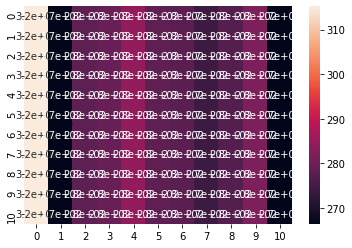

In [20]:
sns.heatmap(confusion_tr, annot=True)

## **Testing**

For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

### **WARNING -- Keep in Mind**

Cheating includes but not limited to:
1.   using testing labels,
2.   submitting results to previous Kaggle competitions,
3.   sharing predictions with others,
4.   copying codes from any creatures on Earth,
5.   asking other people to do it for you.

Any violations bring you punishments from getting a discount on the final grade to failing the course.

It is your responsibility to check whether your code violates the rules.
When citing codes from the Internet, you should know what these codes exactly do.
You will **NOT** be tolerated if you break the rule and claim you don't know what these codes do.


it = iter(test_loader)
a = next(it)[0].to(device)
ae_model.eval()
b = ae_model(a)
import cv2
b = b.to('cpu').detach().numpy().transpose([0, 2, 3, 1])
a = a.to('cpu').detach().numpy().transpose([0, 2, 3, 1])
def norm(img):
    for i in range(3):
        ch = img[:, :, i]
        a = ch.min()
        b = ch.max()
        img[:, :, i] = (ch-a)/(b-a)
    return (img*255).astype('uint8')
for i, img in enumerate(b):
    cv2.imwrite(f"img/{i}.png", norm(img))
    cv2.imwrite(f"img/{i}_.png", norm(a[i]))
    if i == 0:
        break

In [21]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
model = Classifier(*model_).to(device)
model_path = f'./model_{name_t}.ckpt'
model.load_state_dict(torch.load(model_path))
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(rd_test_loader):
    # imgs, _ = batch
    imgs = rd_test_set.merge_batch(batch)

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    # predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    predictions.extend(rd_test_set.merge_predict(logits))

  0%|          | 0/210 [00:00<?, ?it/s]

In [22]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

In [23]:
torch.cuda.empty_cache()